# Salinity Analysis

**Table of Contents**
* [Working Notes](#Working-Notes)
* [Executive Summary](#Executive-Summary)
* [Graphical Analysis](#Graphical-Analysis)
* [Data Analysis](#Data-Analysis)
* [Hypotheses](#Hypotheses)
* [Conclusion](#Conclusion)
* [References](#References)

## Working Notes

As of 11/19:
- TODO
  - Run Miguel's extreme value analysis on the recent model output and using Miguel Pavon's AOI data
  - Track percent flow from Falcon and see if it correlates with salt load
  - Finish preparing repository
    - Make primary analysis notebook parameterized for any reach
    - Update README such that external steps are described
  - Prepare presentation for Dec 3rd meeting
    - 1-2 page report discussing graphs, hypotheses, findings from hypothesis tests, and recommendations
    - Slide deck for presentation
  - Double check that the base data is 11_11, not 11_11a. I'm not sure if I'm misremembering.
  - Check the units for salt load and update
  - Make a short introduction for Statistical Hydrology based on sources you've read
- Observations
  - This was an extra [rainy year](https://www.weather.gov/media/bro/wxevents/2021/pdf/RGV2021SummerSummary.pdf)
  - Anzalduas Dam had large outflows that I'm guessing corresponded with the [planting season](https://hidalgo.agrilife.org/files/2020/09/Vegetable-Planting-Guide-for-Rio-Grande-Valley.pdf)
  - There is a loss of water during high flows, but during mid May there is a reversal of this (gain of water right before a drop in flows). Does this mean that the flow time is off?
  - Salt load is stationary (no seasonality), and autocorrelates heavily with a day or two lag
  - Most of the data is not normally distributed (Pearson correlation is inappropriate)
  - There are steady gains from Puertecitos that seem to correlate with the diff in the flow_in vs flow_out
- Dan comments
  - Lower reaches probably have salinity caused by upper reaches
  - Recommendations need supporting evidence/metrics such as costs associated

## Executive Summary

The goal of this notebook is to provide an easy frame work for graphical and regression analysis on the output from an OASIS model. It is configured to be used with model version 1.1. The focus of this notebook is covering behavior in Reach 2 specifically, from Rio Grande City to Los Ebanos. This is run with basedata_11_11.
- Generate a series of well-formatted graphs that can provide a cursory analysis on the output from the OASIS model.
- Run summary statistical analysis on the time series
- Test certain hypotheses to see if they hold up

In [15]:
# Meta functions
# Change me to `%matplotlib qt` for interactive mode
%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gumbel_r
from sklearn.metrics import mutual_info_score

from src.lib import utils
from src.lib import stats
from src.lib import plot
from src.lib import analysis
from src.lib import constants

In [3]:
# Global variables
pd.set_option('display.max_rows', 1000)

# Set the target reach. Update this so examine your reach specifically
REACH = 2

# This is the time frame for the study, limit all results to this
START = "01/01/2021"
END = "12/31/2023"

In [4]:
# Load the datasets
OASIS_output_file = "data/all_data_11_20.csv"
df = pd.read_csv(
    OASIS_output_file, 
    header=0,  # Read the header
    skipinitialspace=True,  # OASIS outputs have leading spaces
    names=constants.FIELD_NAMES,  # Map the ideal field names to the csv, order matters so make sure the 1v file is 1-1 with the list
    parse_dates=[constants.TIMESTAMP_KEY],  # Process the date string as a datetime
    index_col=constants.TIMESTAMP_KEY  # Set the date as the index for the dataframe
)

# Take the moving average over a 5 day window to smooth out variances introduced by the time to travel value (1 day per reach)
df_5_ma = df.rolling(window=5).mean()

# Get the HUC data as well
df_huc = utils.huc2df(
    files=[f"data/Rain_Ave_Date_{REACH}N.csv", f"data/Rain_Ave_Date_{REACH}S.csv"],
    start=START,
    end=END,
)

## Graphical Analysis

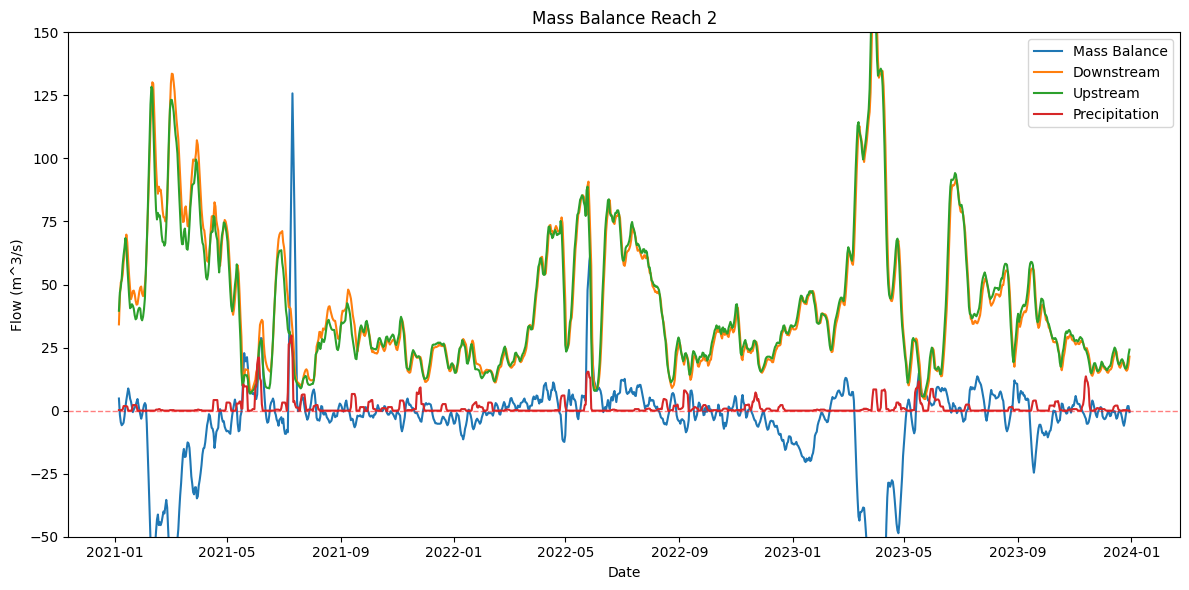

In [5]:
# Mass Balance
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(-50,150)

sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'MassBalanceR{REACH}', data=df_5_ma, ax=ax1, label='Mass Balance')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'DownstreamR{REACH}', data=df_5_ma, ax=ax1, label='Downstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'UpstreamR{REACH}', data=df_5_ma, ax=ax1, label='Upstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'PrecipitationR{REACH}', data=df_5_ma, ax=ax1, label='Precipitation')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='upper left')

plt.title(f'Mass Balance Reach {REACH}')
plt.legend()
plt.tight_layout()
plt.show()

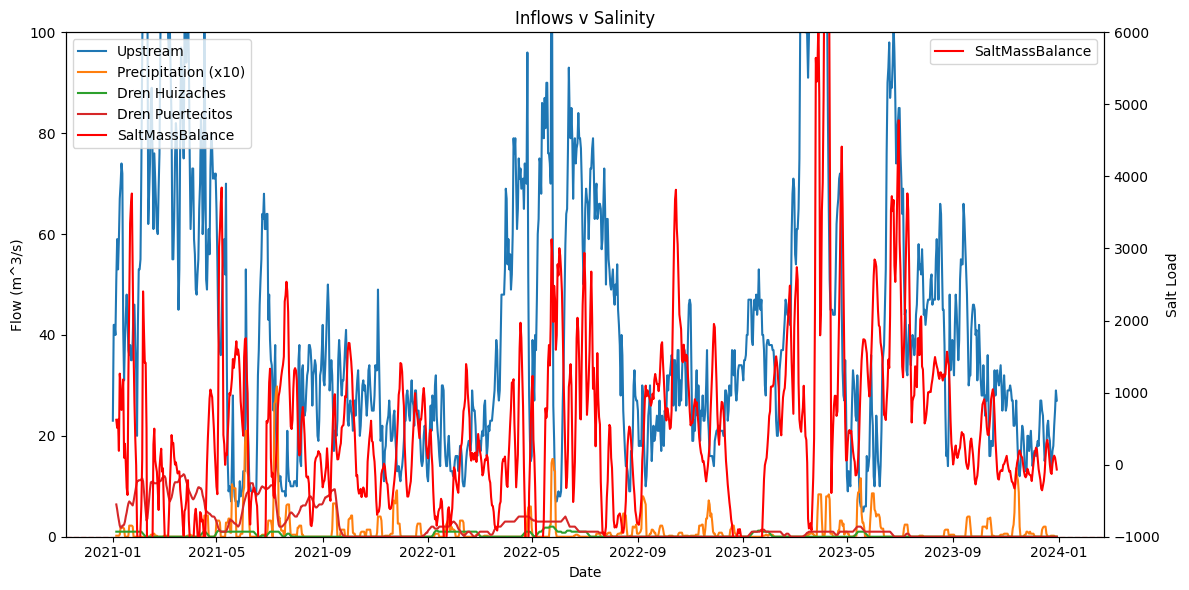

In [6]:
# Inflows Versus Salinity
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(0,100)

sns.lineplot(x=constants.TIMESTAMP_KEY, y='UpstreamR2', data=df, ax=ax1, label='Upstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y='PrecipitationR2', data=df_5_ma, ax=ax1, label='Precipitation (x10)')
sns.lineplot(x=constants.TIMESTAMP_KEY, y='DrenHuizaches', data=df_5_ma, ax=ax1, label='Dren Huizaches')
sns.lineplot(x=constants.TIMESTAMP_KEY, y='DrenIndiosPuertecitos', data=df_5_ma, ax=ax1, label='Dren Puertecitos')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Salt Load')
ax2.set_ylim(-1000,6000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SaltMassBalanceR{REACH}', data=df_5_ma, ax=ax2, color='red', label='SaltMassBalance')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Inflows v Salinity')
plt.legend()
plt.tight_layout()
plt.show()

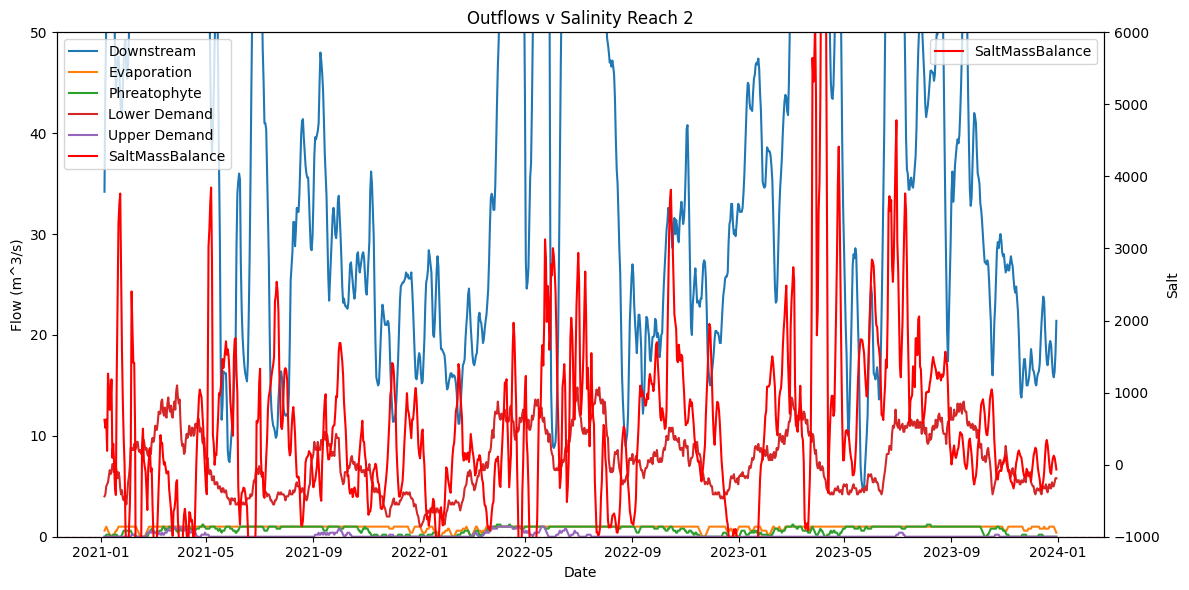

In [7]:
# Outflows Versus Salinity
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(0,50)

sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'DownstreamR{REACH}', data=df_5_ma, ax=ax1, label='Downstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'EvaporationR{REACH}', data=df_5_ma, ax=ax1, label='Evaporation')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'PhreatophyteR{REACH}', data=df_5_ma, ax=ax1, label='Phreatophyte')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'LowerDemandTXR{REACH}', data=df_5_ma, ax=ax1, label='Lower Demand')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'UpperDemandTXR{REACH}', data=df_5_ma, ax=ax1, label='Upper Demand')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Salt')
ax2.set_ylim(-1000,6000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SaltMassBalanceR{REACH}', data=df_5_ma, ax=ax2, color='red', label='SaltMassBalance')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Outflows v Salinity Reach {REACH}')
plt.legend()
plt.tight_layout()
plt.show()

### Salt MB

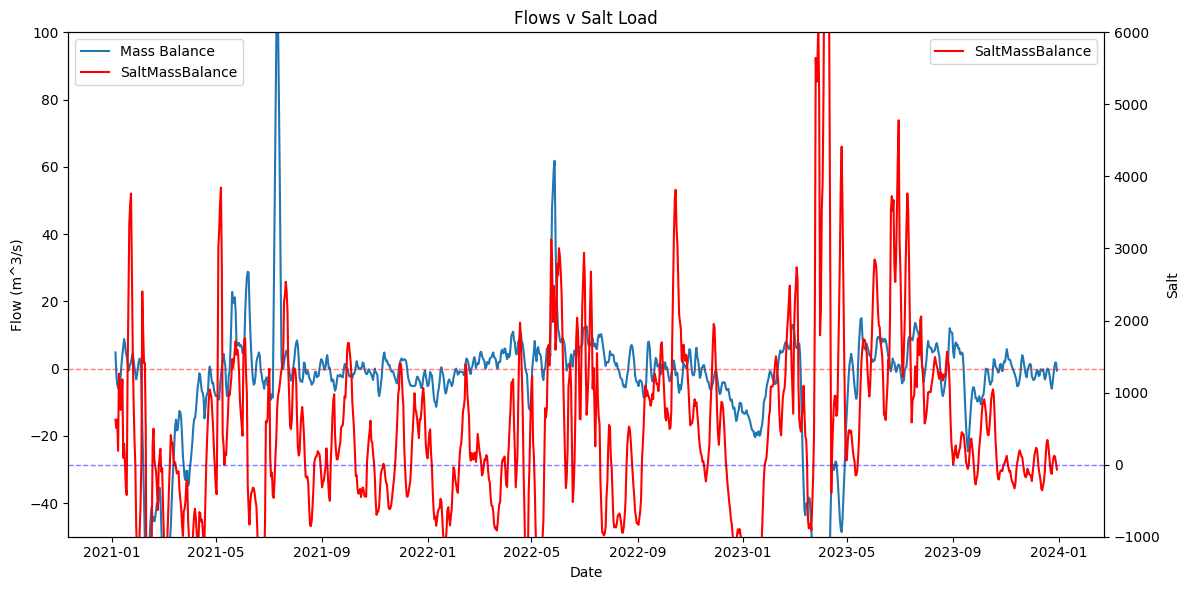

In [8]:
# Plot salt load on key flows
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(-50,100)

sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'MassBalanceR{REACH}', data=df_5_ma, ax=ax1, label='Mass Balance')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Salt')
ax2.set_ylim(-1000,6000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SaltMassBalanceR{REACH}', data=df_5_ma, ax=ax2, color='red', label='SaltMassBalance')

ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Flows v Salt Load')
plt.legend()
plt.tight_layout()
plt.show()

## Data Analysis

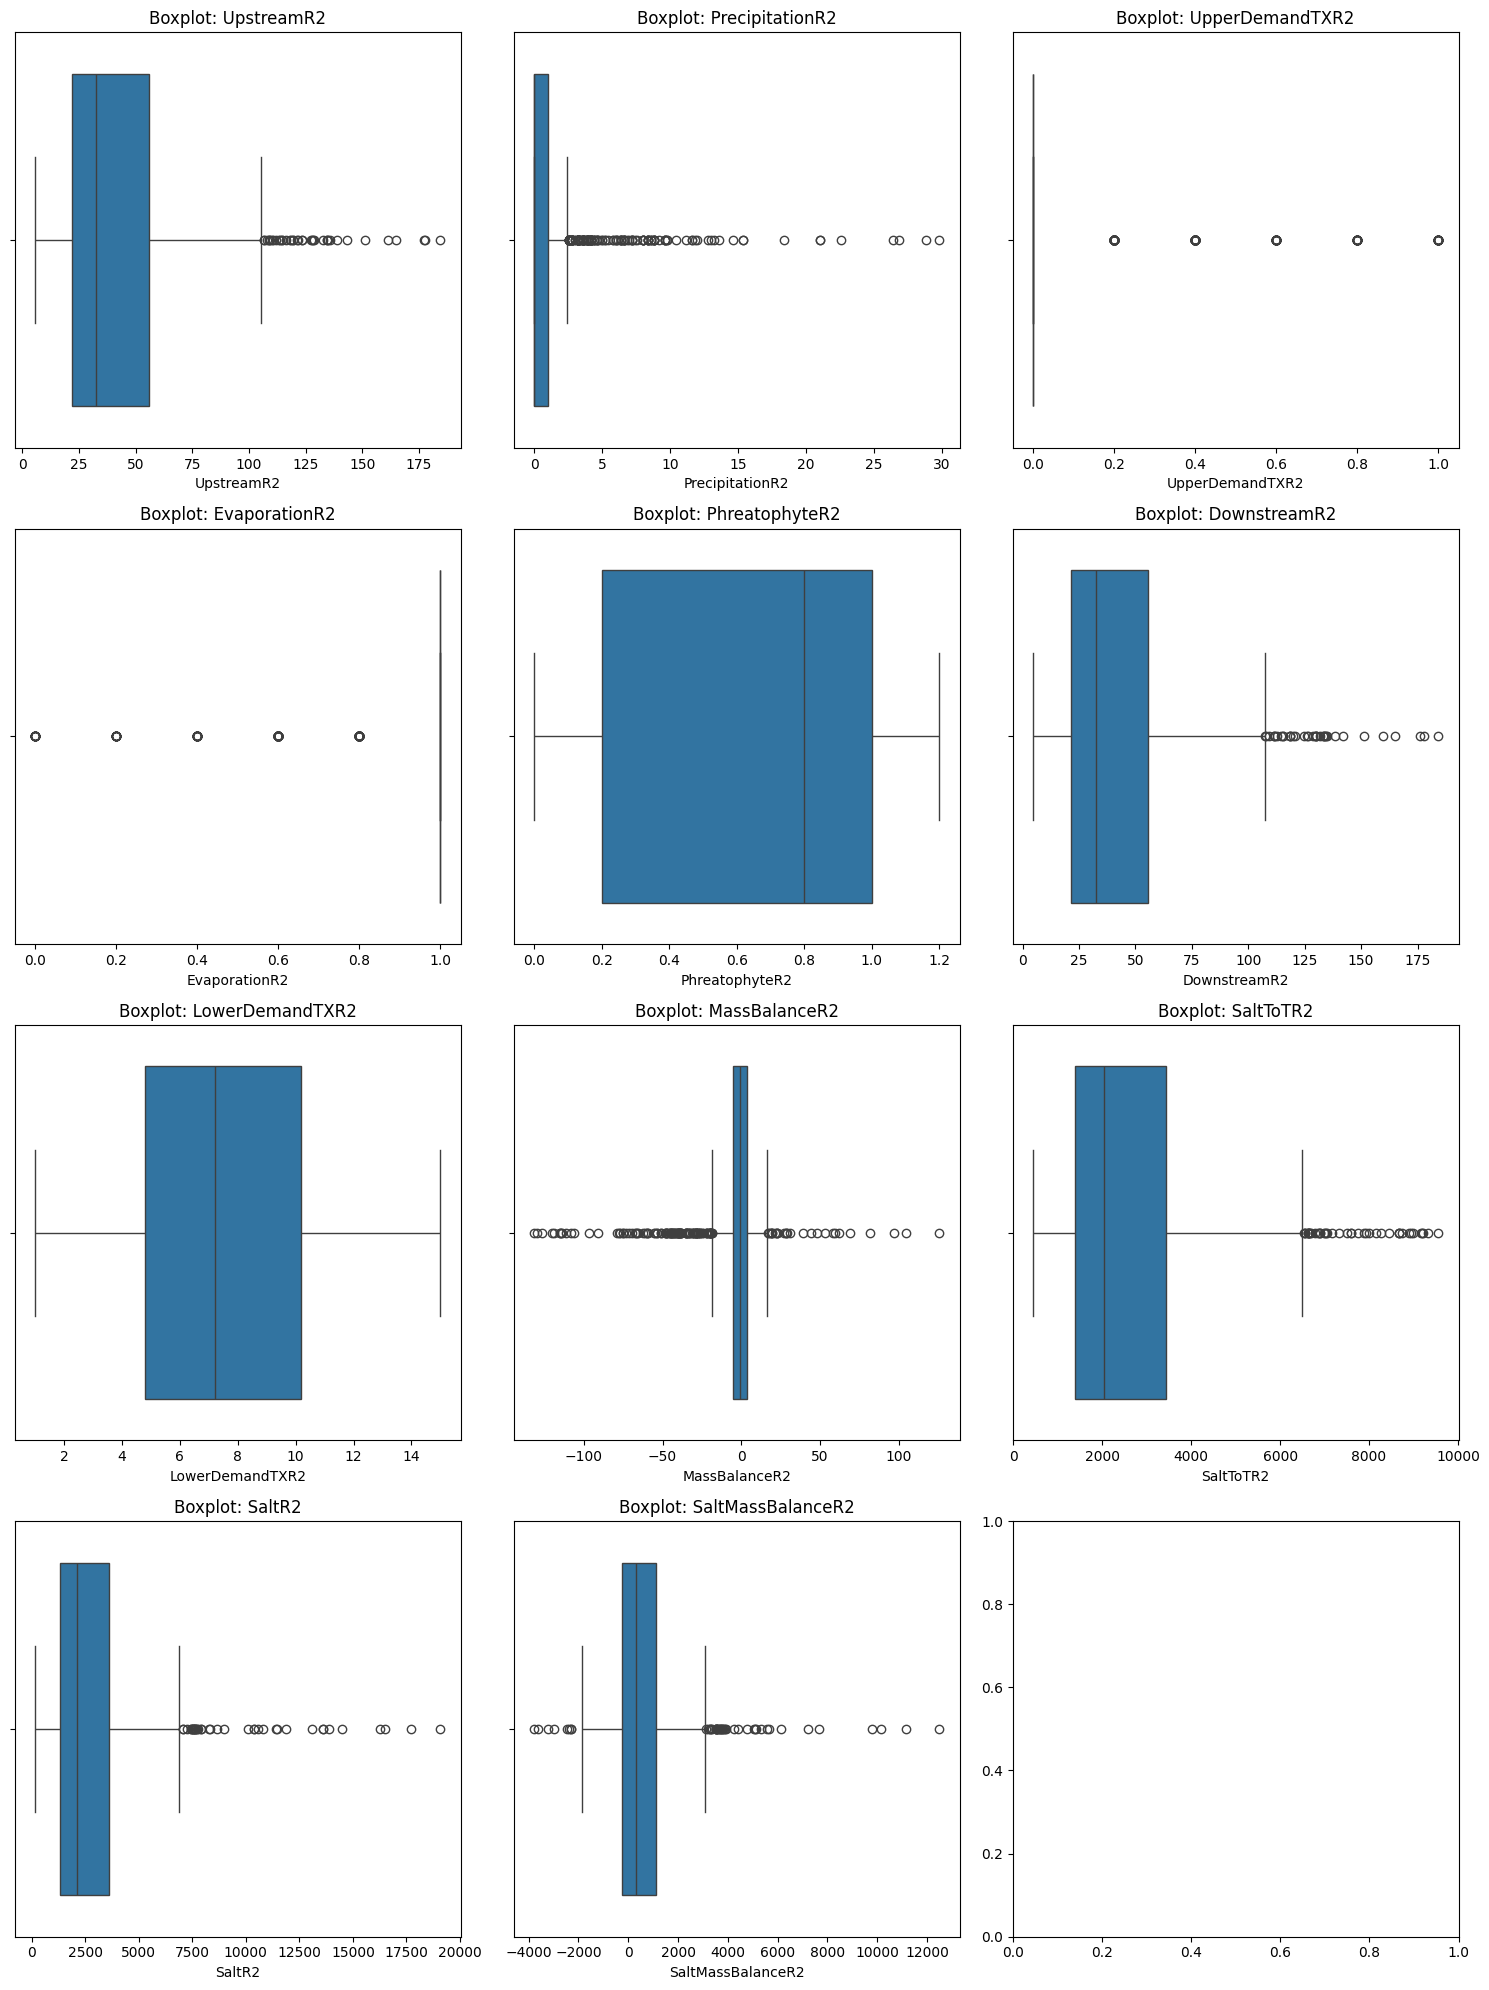

In [9]:
stats.plot_boxplot(df_5_ma, utils.get_reach_fields(reach=REACH))

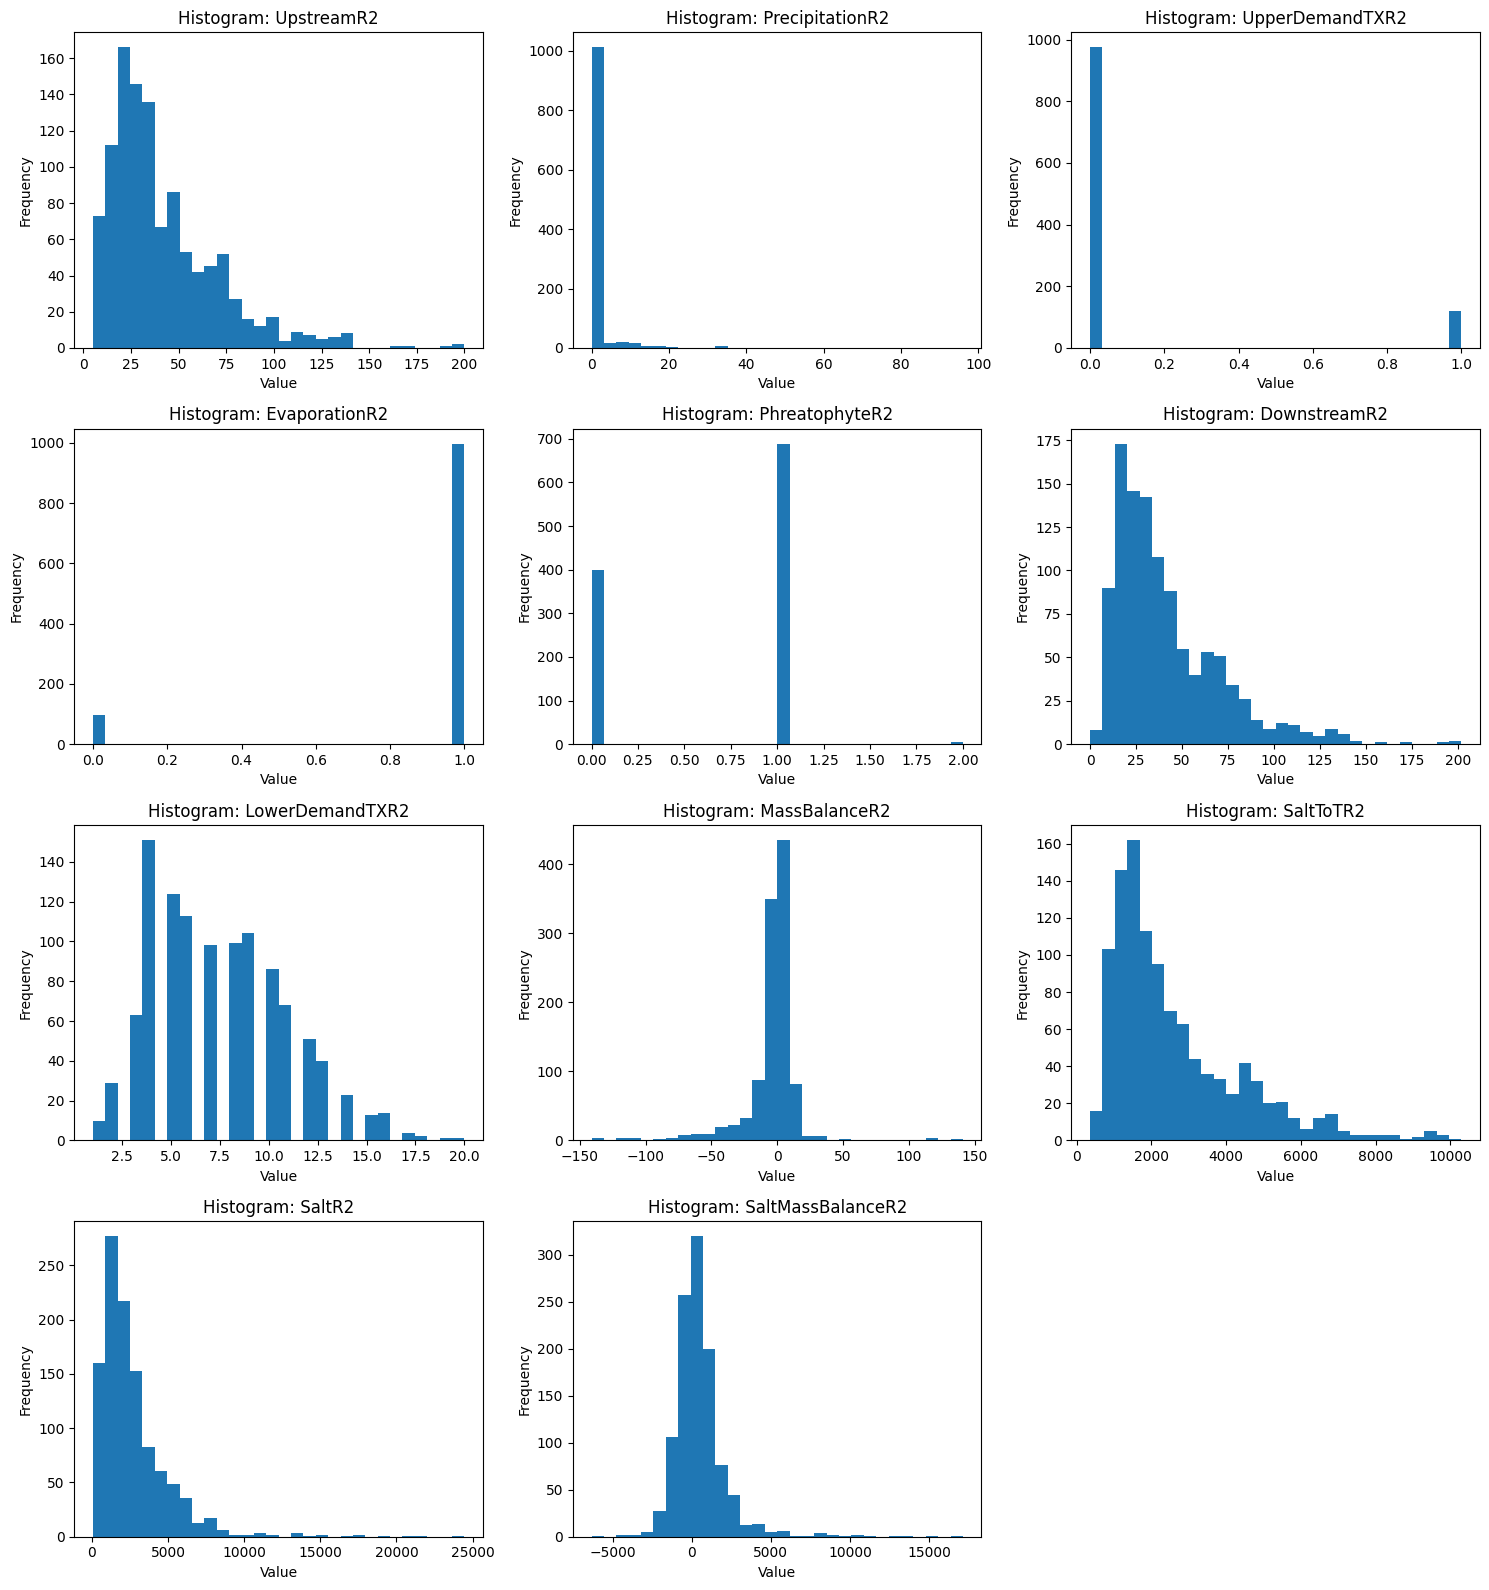

In [10]:
stats.plot_histogram(df, utils.get_reach_fields(reach=REACH))


SaltR2

ADF Statistic: -4.3806655165428845
p-value: 0.00032111331029587405
Critical Values: 
	 1%: -3.4364533503600962
	 5%: -2.864234857527328
	 10%: -2.568204837482531
True


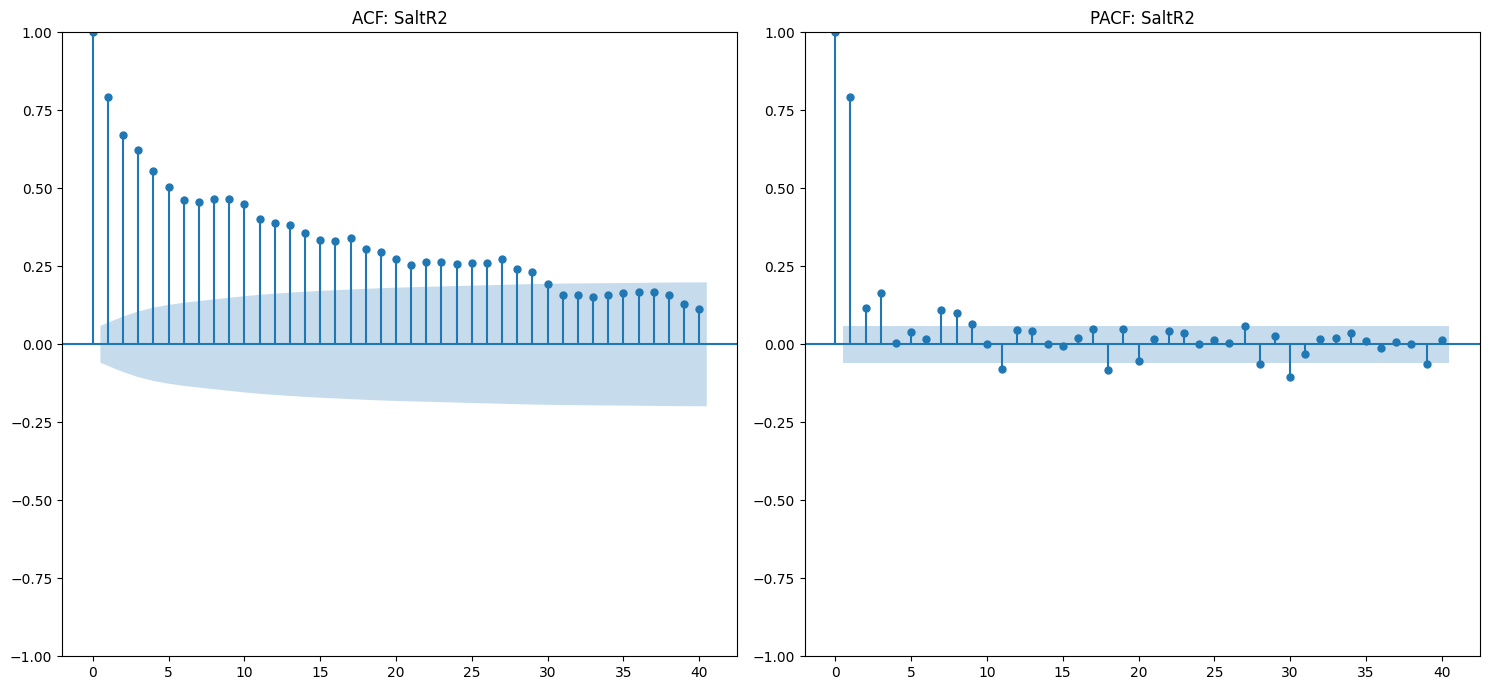

In [11]:
# Is salinity periodic?
print(stats.check_stationarity(df, f"SaltR{REACH}"))
stats.plot_acf_pacf(df, [f"SaltR{REACH}"])

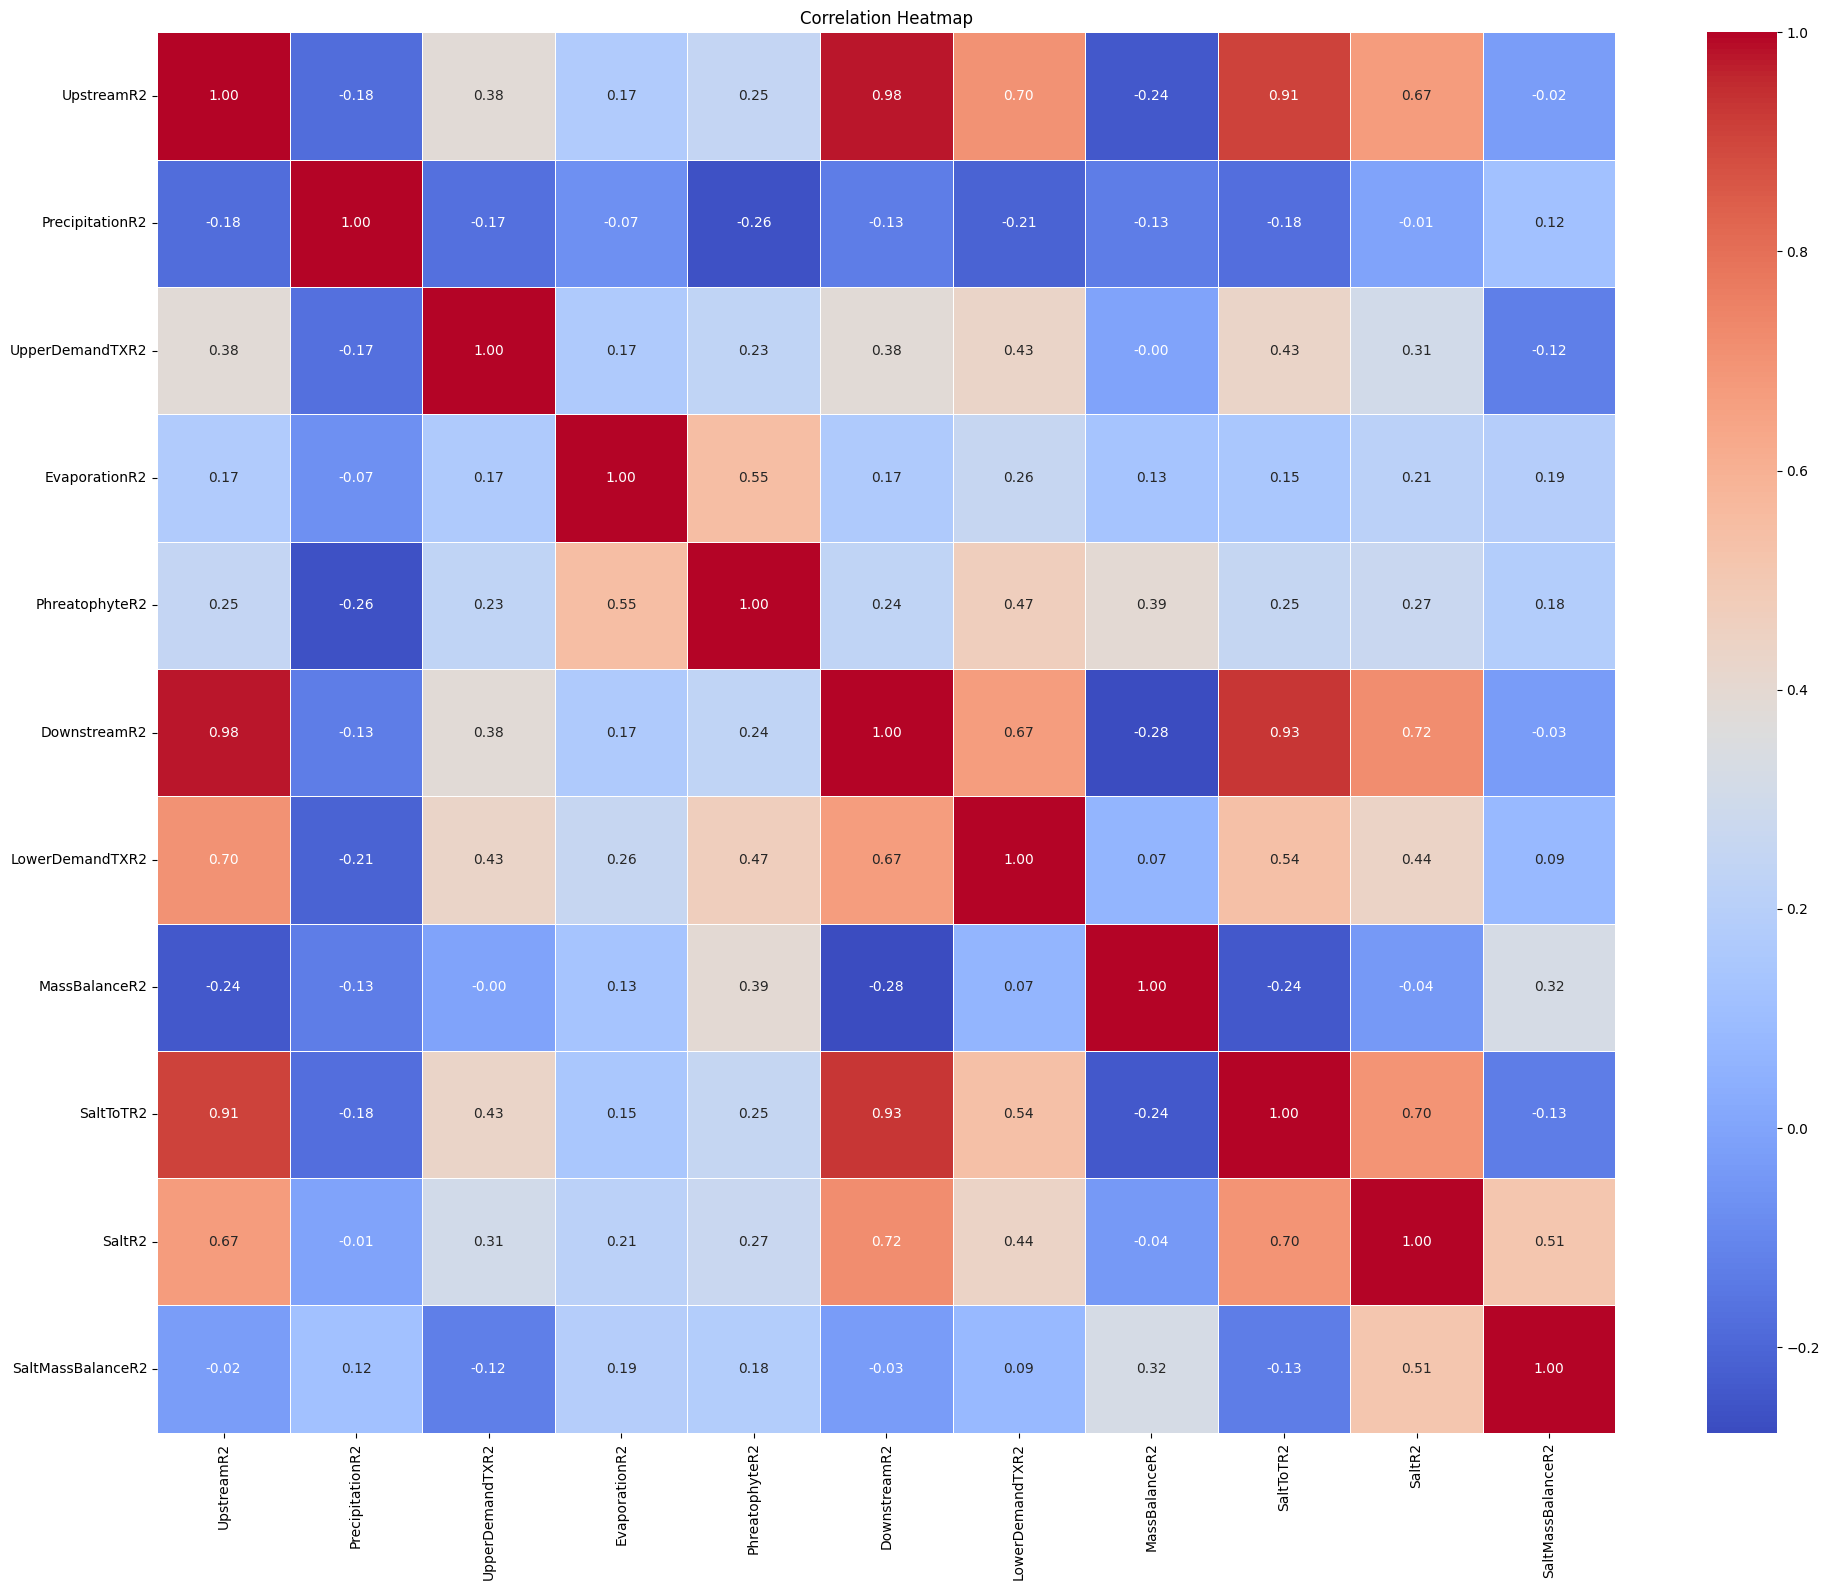

In [12]:
stats.plot_correlation_heatmap(df_5_ma[utils.get_reach_fields(reach=REACH)])

In [13]:
stats.get_stats(df, utils.get_reach_fields(reach=REACH))

,mean,median,std_dev,variance
UpstreamR2,41.254113,33.0,28.514701,8.130882e+02
PrecipitationR2,1.243144,0.0,5.510808,3.036901e+01
UpperDemandTXR2,0.108775,0.0,0.311499,9.703180e-02
EvaporationR2,0.911335,1.0,0.284390,8.087781e-02
PhreatophyteR2,0.640768,1.0,0.491298,2.413740e-01
DownstreamR2,41.734004,33.0,29.294723,8.581808e+02
LowerDemandTXR2,7.492687,7.0,3.440175,1.183480e+01
MassBalanceR2,-4.197441,-1.0,22.384181,5.010516e+02
SaltToTR2,2627.804388,2050.0,1760.832347,3.100531e+06
SaltR2,2734.001828,2050.5,2493.474868,6.217417e+06


## Hypotheses

- Flood releases from Falcon cause peaks in salinity
- Precipitation events cause peaks in salinity
- Why is the salinity at Los Ebanos so variable?

## Conclusion



## References